# Monte Carlo Markov Chain sampling of COVID-19 infections

#### Author: leebond
#### Date: Feb 2020

In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os, re, sys
import emcee as mc

from helper_fun_model import *
from mcmcHelperFunctions import mh

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

# Case 1: Simulate Hubei infection numbers
## Data source
#### source https://github.com/BlankerL/DXY-COVID-19-Data

In [2]:
%%time
## Query and save new data 
! cd ./data_processing && python DXY_AreaData_query.py

2020-02-21 17:51:11Update records successfully to ../data/DXY_Chinese.csv
Save area daily dataset (English) into ../data/DXYArea.csv
Wall time: 19.8 s


In [3]:
## Load data 
df = pd.read_csv("./data/DXYArea.csv")
"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incomplete)

df.tail(3) # check new

,date,country,countryCode,province,city,confirmed,suspected,cured,dead,Days,net_confirmed
7365,2020-02-20,泰国,TH,NaN,NaN,35,0,17,0,74,18
7366,2020-02-20,美国,US,NaN,NaN,15,0,3,0,74,12
7367,2020-02-20,越南,VN,NaN,NaN,16,0,9,0,74,7


In [4]:
df_ = df[df['date'] > datetime.datetime(2020, 1, 22)] # cutting off from before date of Wuhan city lockdown

case = get_China_total(df_) # get all of China's infection numbers

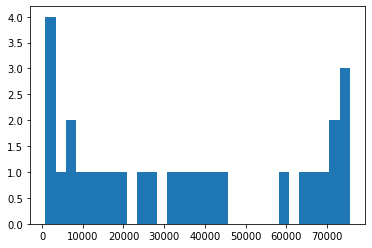

In [5]:
plt.hist(case['confirmed'], bins = 30)
plt.show()

#### Using the daily change in infection number as a random variable we want to model
- the change in the infection numbers from day to day can tell us the force of infection per day. In other words, it can also be thought of as the infection rate which we could model as a random variable.
- to do so i simply do `diff()` which takes the first 'lag' of the infection column. Notice that the first row will not have any number since there is no 'lag'. Therefore, I fill the first record as 1 for simplicity yet it can't be 0 since there 'should' be some kind of new infection from day to day.

In [6]:
case['new infected'] = case['confirmed'].diff().fillna(1)

In [7]:
case.head(10)

,date,country,countryCode,province,city,confirmed,suspected,cured,dead,Days,net_confirmed,new infected
308,2020-01-23,中国,CN,NaN,NaN,830,1072,34,25,46,771,1.0
460,2020-01-24,中国,CN,NaN,NaN,1287,1965,38,41,47,1208,457.0
661,2020-01-25,中国,CN,NaN,NaN,1975,2684,49,56,48,1870,688.0
890,2020-01-26,中国,CN,NaN,NaN,2744,5794,51,80,49,2613,769.0
1164,2020-01-27,中国,CN,NaN,NaN,4515,6973,60,106,50,4349,1771.0
1452,2020-01-28,中国,CN,NaN,NaN,5974,9239,103,132,51,5739,1459.0
1760,2020-01-29,中国,CN,NaN,NaN,7711,12167,124,170,52,7417,1737.0
2077,2020-01-30,中国,CN,NaN,NaN,9692,15238,171,213,53,9308,1981.0
2399,2020-01-31,中国,CN,NaN,NaN,11791,17988,243,259,54,11289,2099.0
2728,2020-02-01,中国,CN,NaN,NaN,14380,19544,328,304,55,13748,2589.0


In [8]:
case.shape

(29, 12)

## EDA

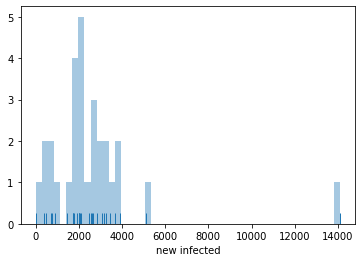

In [9]:
sb.distplot(case['new infected'], bins=50, kde=False, rug=True)

### Creating a gamma fit to the data
- the belief distribution is that the infection rate follows a gamma distribution.
- A gamma distribution is continuous, does not take on negative values and its flexible since it takes on two parameters; shape and scale
- several research papers have used gamma to model infection rates (google abit and you will see many using gamma)

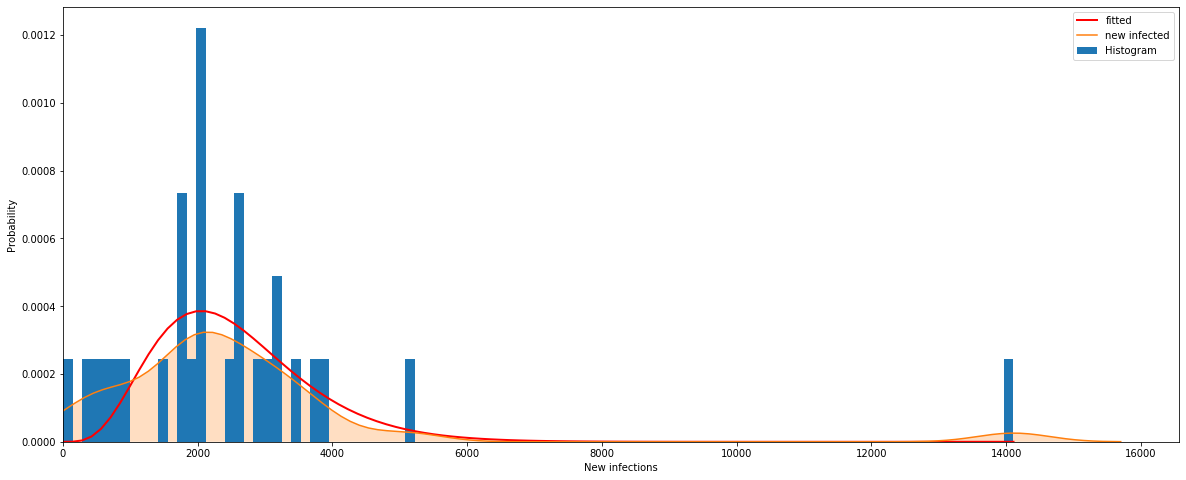

In [10]:
shape, scale = 5.1, 500 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Some comments about the fitting
- The density plot is **missing some data** because we did not include counts from the earlier days of the outbreak (we have it but it is highly unreliable) 
- therefore the density distribution do not have new infection numbers that is near 0

# MCMC
- Why MCMC?
 - it offers us a robust method to draw samples from our posterior ie. allow us to bootstrap our data (new infection) to test a distribution
 - with the sampled distribution we can use MLE to find the parameters of the distribution
 - since our belief is a gamma distribution, we do the MLE for gamma
 - with the shape and scale parameters of gamma, we create an actual gamma distribution with these parameters, allowing us to forecast/predict samples that fall within the distribution of gamma. 
 - we do not know exactly what tomorrow's new infection number will be. But we can know the mean and variance of the gamma distribution + today's infection number = gives us tomorrow's infection count. 
 - Yes, it doesn't tell us in the future when and what the infection count will be (it doesnt forecast).

In [11]:
mu = case['new infected'].mean()
sigma = case['new infected'].std()

In [12]:
mu, sigma

(2577.1724137931033, 2499.100038999261)

iter: 5000.0
Theta: 100
Mean of samples: 1745.0704856524228, Stddev of samples: 737.4029946058777
Theta: 2100
Mean of samples: 2512.54065220547, Stddev of samples: 1120.2221791511497
Theta: 4100
Mean of samples: 2511.924747132013, Stddev of samples: 1000.6740645526186
Theta: 6100
Mean of samples: 2586.7429994775293, Stddev of samples: 1887.3166589029374
Theta: 8100
Mean of samples: 3386.927201378736, Stddev of samples: 1678.6791595949703
iter: 12500.0
Theta: 100
Mean of samples: 2295.605555169821, Stddev of samples: 1033.5435493137243
Theta: 2100
Mean of samples: 1935.2109789834458, Stddev of samples: 869.2627318834801
Theta: 4100
Mean of samples: 2565.1097298867107, Stddev of samples: 1071.3617255635772
Theta: 6100
Mean of samples: 2255.215311301596, Stddev of samples: 1187.1750089937718
Theta: 8100
Mean of samples: 2309.7029971250067, Stddev of samples: 1107.571992225844
iter: 20000.0
Theta: 100
Mean of samples: 2321.926711402906, Stddev of samples: 1096.1855660560143
Theta: 2100
Mea

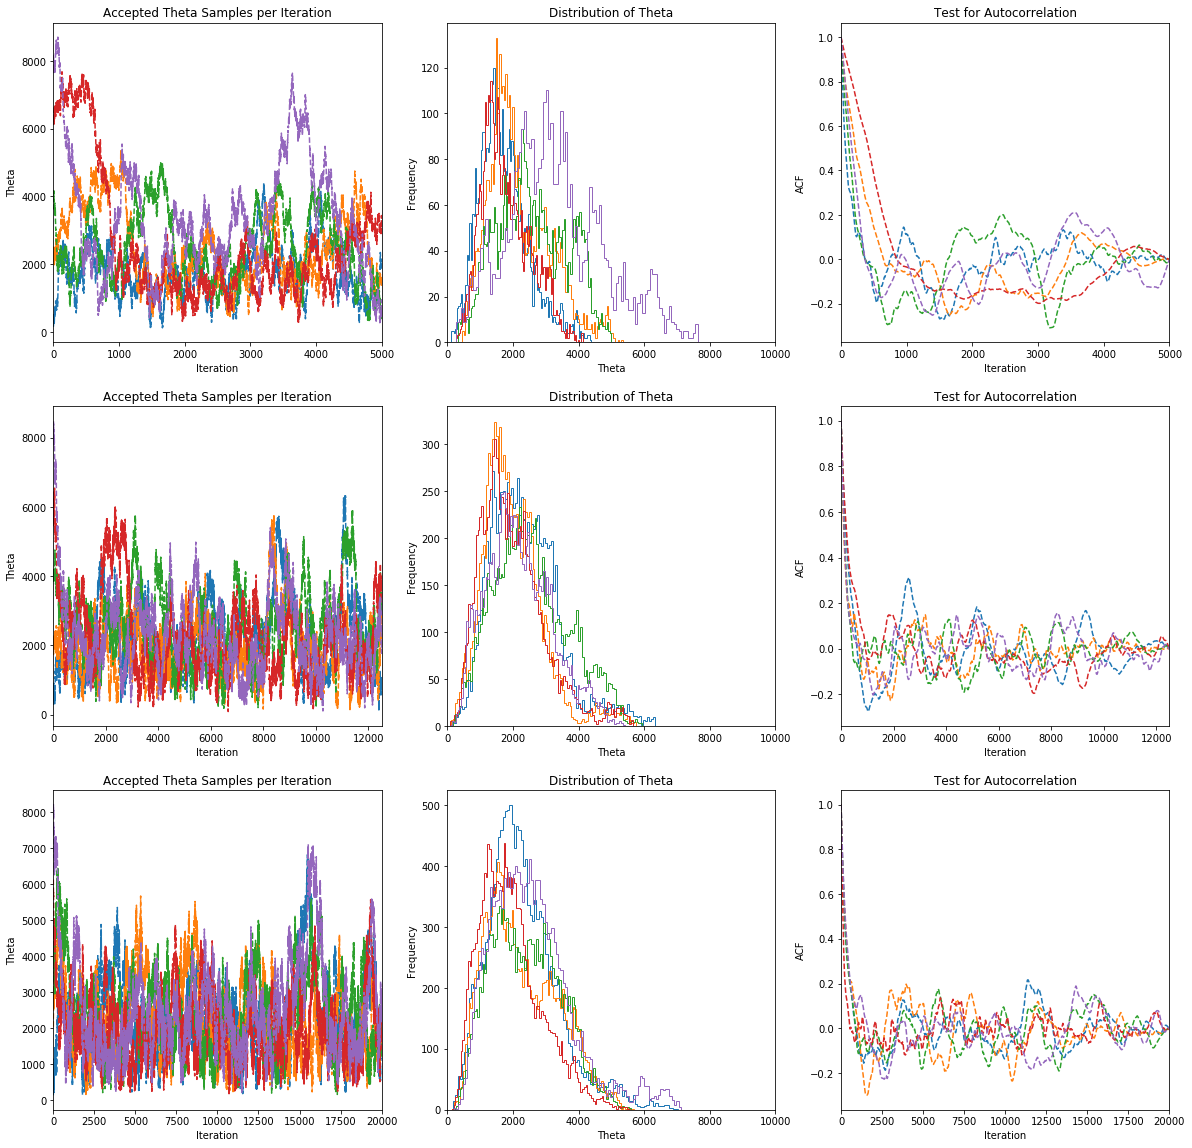

In [13]:
from scipy.stats import gamma, norm, lognorm, weibull_min

niters = np.linspace(5e3,2e4,3)
cnt = 1

fig = plt.figure(figsize=(20,20))

for i in range(len(niters)):
    print("iter: %s" %niters[i])
    
    # select a sigma for the algo, 
    # a range too wide gives you lower chances of accepting samples but allows more room for the candidate data to roam
    # a range too narrow gives you higher chance of accepting samples but samples may not converge
    sigma = 100

    # select different starting points for mu based on its range
    sampless = [mh(niters[i], mu_, sigma, gamma, 4.3, 500).run() for mu_ in np.arange(100, 10000, 2000)]
    
    # Samples plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:    
        ax.plot(samples, '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('Theta')
    ax.set_xlabel('Iteration')
    ax.set_title('Accepted Theta Samples per Iteration')
    cnt += 1
    
    # Distribution plot
    ax = fig.add_subplot(3,3,i+cnt)
    last_n_samples = int(niters[i] * 0.8)
    for samples in sampless:
        ax.hist(samples[-last_n_samples:], bins=100, histtype='step', label=f'{niters[i]}')
    ax.set_xlim([0, 10000])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Theta')
    ax.set_title('Distribution of Theta')
    cnt += 1
    
    # Auto-correlation plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:
        ax.plot(mc.autocorr.function_1d(samples), '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('ACF')
    ax.set_xlabel('Iteration')
    ax.set_title('Test for Autocorrelation')

plt.show()

### Significance test for autocorrelation

In [ ]:
import statsmodels as sm

# Dublin-Watson test for autocorrelation
sm.stats.stattools.durbin_watson

## Case 2: Simulate Hubei infection numbers

In [14]:
case_hubei = get_province_df(df_, 'Hubei Province')

In [15]:
case_hubei.head(10)

,date,country,countryCode,province,city,confirmed,suspected,cured,dead,Days,net_confirmed
383,2020-01-23,中国,CN,Hubei Province,NaN,549,0,31,24,46,494
568,2020-01-24,中国,CN,Hubei Province,NaN,729,0,32,39,47,658
784,2020-01-25,中国,CN,Hubei Province,NaN,1052,0,42,52,48,958
1039,2020-01-26,中国,CN,Hubei Province,NaN,1423,0,44,76,49,1303
1318,2020-01-27,中国,CN,Hubei Province,NaN,2714,0,47,100,50,2567
1614,2020-01-28,中国,CN,Hubei Province,NaN,3554,0,80,125,51,3349
1925,2020-01-29,中国,CN,Hubei Province,NaN,4586,0,90,162,52,4334
2243,2020-01-30,中国,CN,Hubei Province,NaN,5806,0,116,204,53,5486
2570,2020-01-31,中国,CN,Hubei Province,NaN,7153,0,166,249,54,6738
2900,2020-02-01,中国,CN,Hubei Province,NaN,9074,0,215,294,55,8565


In [16]:
case_hubei['new infected'] = case_hubei['confirmed'].diff().fillna(1)

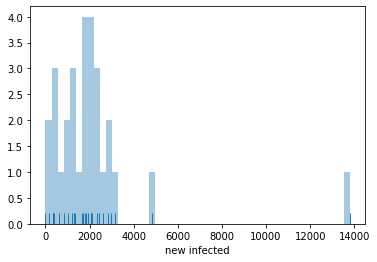

In [17]:
sb.distplot(case_hubei['new infected'], bins=50, kde=False, rug=True)

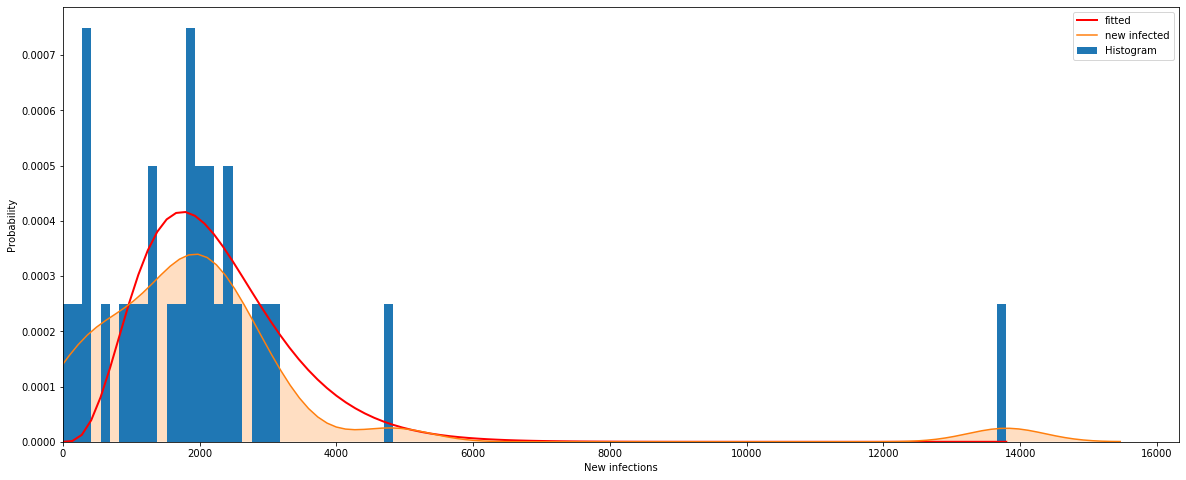

In [18]:
shape, scale = 4.5, 500 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_hubei['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_hubei['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [19]:
mu = case_hubei['new infected'].mean()
sigma = case_hubei['new infected'].std()
mu, sigma

(2141.862068965517, 2478.232718867822)

iter: 5000.0
Theta: 100
Mean of samples: 1883.8101143726926, Stddev of samples: 892.5445873645965
Theta: 2100
Mean of samples: 1825.5079947013817, Stddev of samples: 610.3029332503819
Theta: 4100
Mean of samples: 2159.086606453922, Stddev of samples: 1070.6250139954243
Theta: 6100
Mean of samples: 2806.8267724355464, Stddev of samples: 1391.4778906103143
Theta: 8100
Mean of samples: 2264.782523948186, Stddev of samples: 1678.9703621426313
iter: 12500.0
Theta: 100
Mean of samples: 2164.0647153873924, Stddev of samples: 878.4494956742423
Theta: 2100
Mean of samples: 2447.6564984502775, Stddev of samples: 1150.3452037136406
Theta: 4100
Mean of samples: 2047.5033240528994, Stddev of samples: 880.2877366976004
Theta: 6100
Mean of samples: 2106.5828172317815, Stddev of samples: 900.2679903444135
Theta: 8100
Mean of samples: 2351.755758303226, Stddev of samples: 1148.8084556425063
iter: 20000.0
Theta: 100
Mean of samples: 2183.6307759526185, Stddev of samples: 835.7738631051742
Theta: 2100
Me

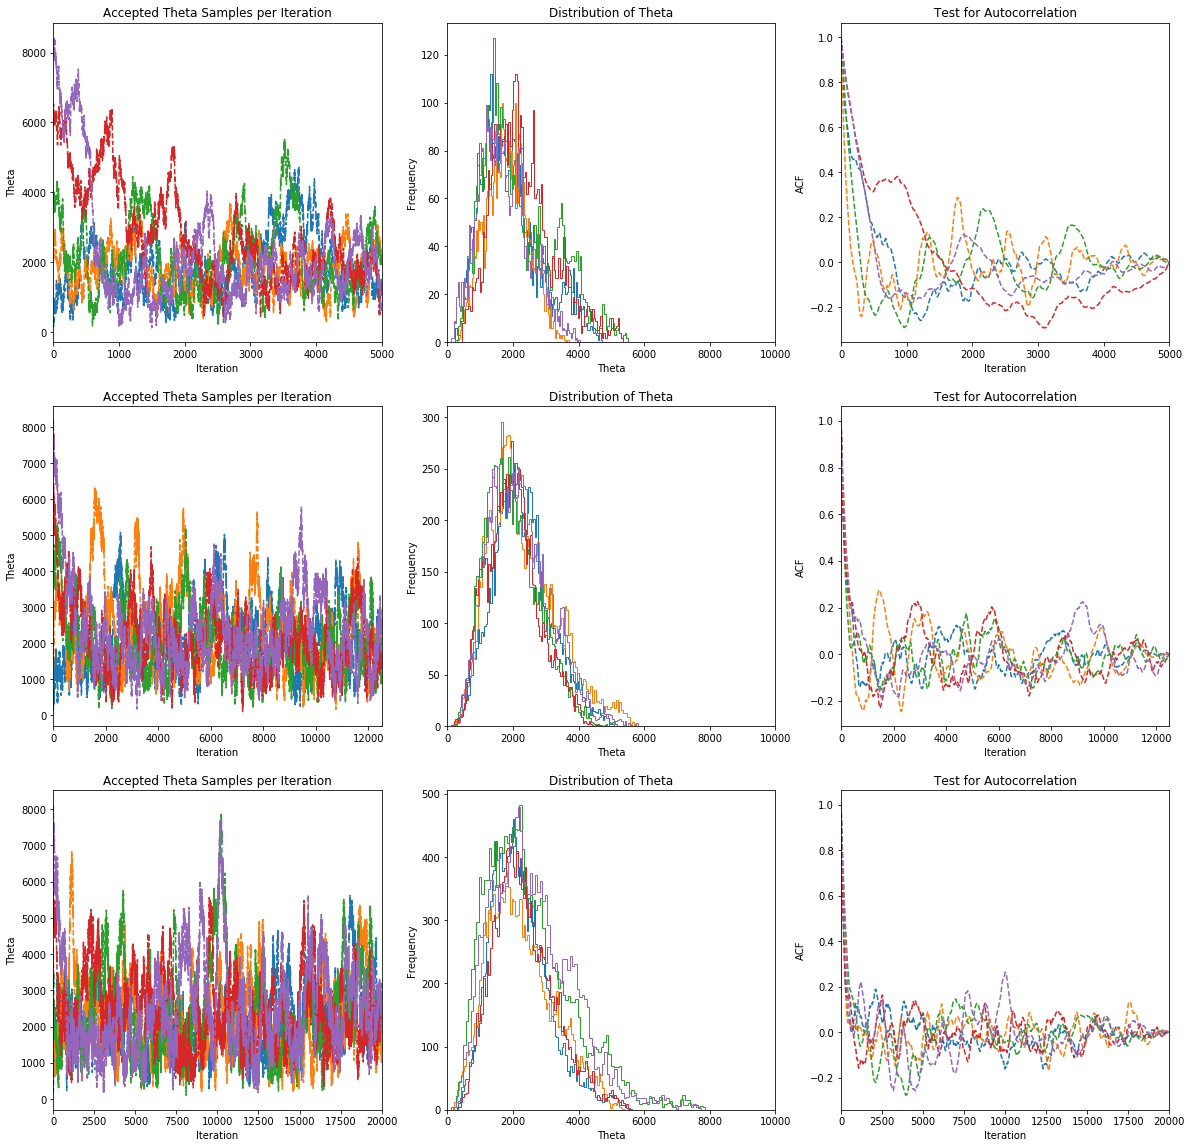

In [20]:
from scipy.stats import gamma, norm, lognorm, weibull_min

niters = np.linspace(5e3,2e4,3)
cnt = 1

fig = plt.figure(figsize=(20,20))

for i in range(len(niters)):
    print("iter: %s" %niters[i])
    
    # select a sigma for the algo, 
    # a range too wide gives you lower chances of accepting samples but allows more room for the candidate data to roam
    # a range too narrow gives you higher chance of accepting samples but samples may not converge
    sigma = 100

    # select different starting points for mu based on its range
    sampless = [mh(niters[i], mu_, sigma, gamma, 4.5, 500).run() for mu_ in np.arange(100, 10000, 2000)]
    
    # Samples plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:    
        ax.plot(samples, '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('Theta')
    ax.set_xlabel('Iteration')
    ax.set_title('Accepted Theta Samples per Iteration')
    cnt += 1
    
    # Distribution plot
    ax = fig.add_subplot(3,3,i+cnt)
    last_n_samples = int(niters[i] * 0.8)
    for samples in sampless:
        ax.hist(samples[-last_n_samples:], bins=100, histtype='step', label=f'{niters[i]}')
    ax.set_xlim([0, 10000])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Theta')
    ax.set_title('Distribution of Theta')
    cnt += 1
    
    # Auto-correlation plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:
        ax.plot(mc.autocorr.function_1d(samples), '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('ACF')
    ax.set_xlabel('Iteration')
    ax.set_title('Test for Autocorrelation')

plt.show()

### Significance test for autocorrelation

In [ ]:
import statsmodels as sm

# Dublin-Watson test for autocorrelation
sm.stats.stattools.durbin_watson

## Case 3: Simulate China, ex-Hubei infection numbers

In [21]:
case_exHubei = get_China_exhubei(df_).groupby('date').agg({'confirmed':'sum'}).reset_index()

In [22]:
case_exHubei['new infected'] = case_exHubei['confirmed'].diff().fillna(1)

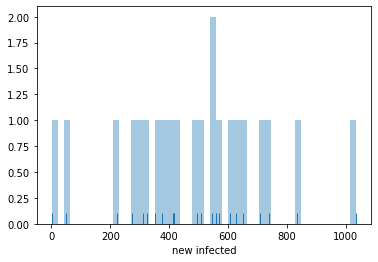

In [23]:
sb.distplot(case_exHubei['new infected'], bins=50, kde=False, rug=True)

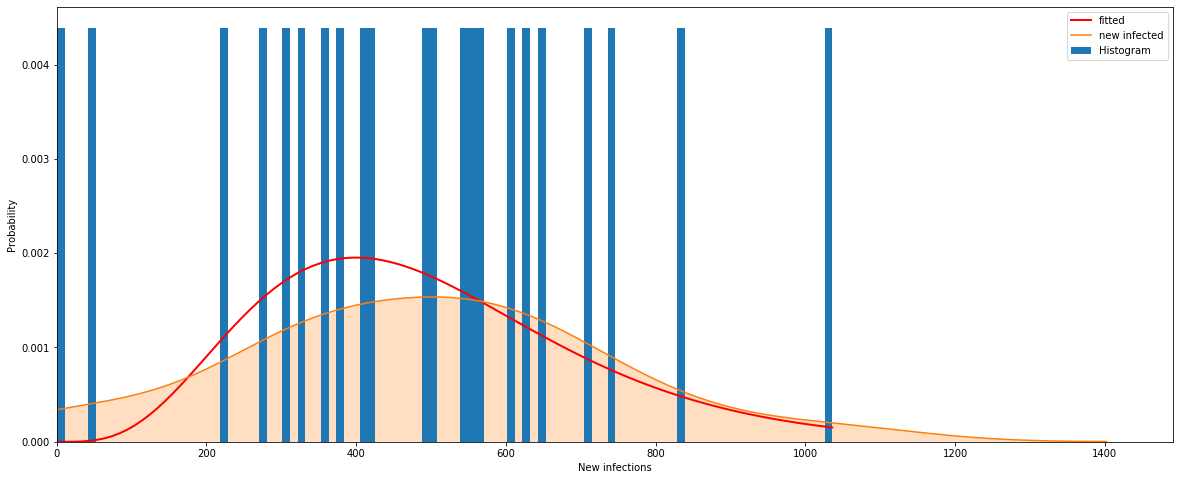

In [24]:
shape, scale = 5, 100 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_exHubei['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_exHubei['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [25]:
mu = case_exHubei['new infected'].mean()
sigma = case_exHubei['new infected'].std()
mu, sigma

(482.8636363636364, 244.26864513414526)

iter: 5000.0
Theta: 100
Mean of samples: 455.1915130964238, Stddev of samples: 218.91015534856376
Theta: 2100
Mean of samples: 445.76885809369816, Stddev of samples: 224.99389624194532
Theta: 4100
Mean of samples: 485.95739384995403, Stddev of samples: 451.4391145207167
Theta: 6100
Mean of samples: 497.6933541113141, Stddev of samples: 633.3894022208949
Theta: 8100
Mean of samples: 638.4940670066061, Stddev of samples: 990.262366754544
iter: 12500.0
Theta: 100
Mean of samples: 435.2505239360072, Stddev of samples: 199.9297015571919
Theta: 2100
Mean of samples: 443.82047178781403, Stddev of samples: 204.93362192220627
Theta: 4100
Mean of samples: 439.5068406416605, Stddev of samples: 253.76582998209008
Theta: 6100
Mean of samples: 491.1309156507198, Stddev of samples: 463.02657033771817
Theta: 8100
Mean of samples: 524.393152040325, Stddev of samples: 735.5452780615977
iter: 20000.0
Theta: 100
Mean of samples: 447.13295158800287, Stddev of samples: 212.39897540787538
Theta: 2100
Mean of

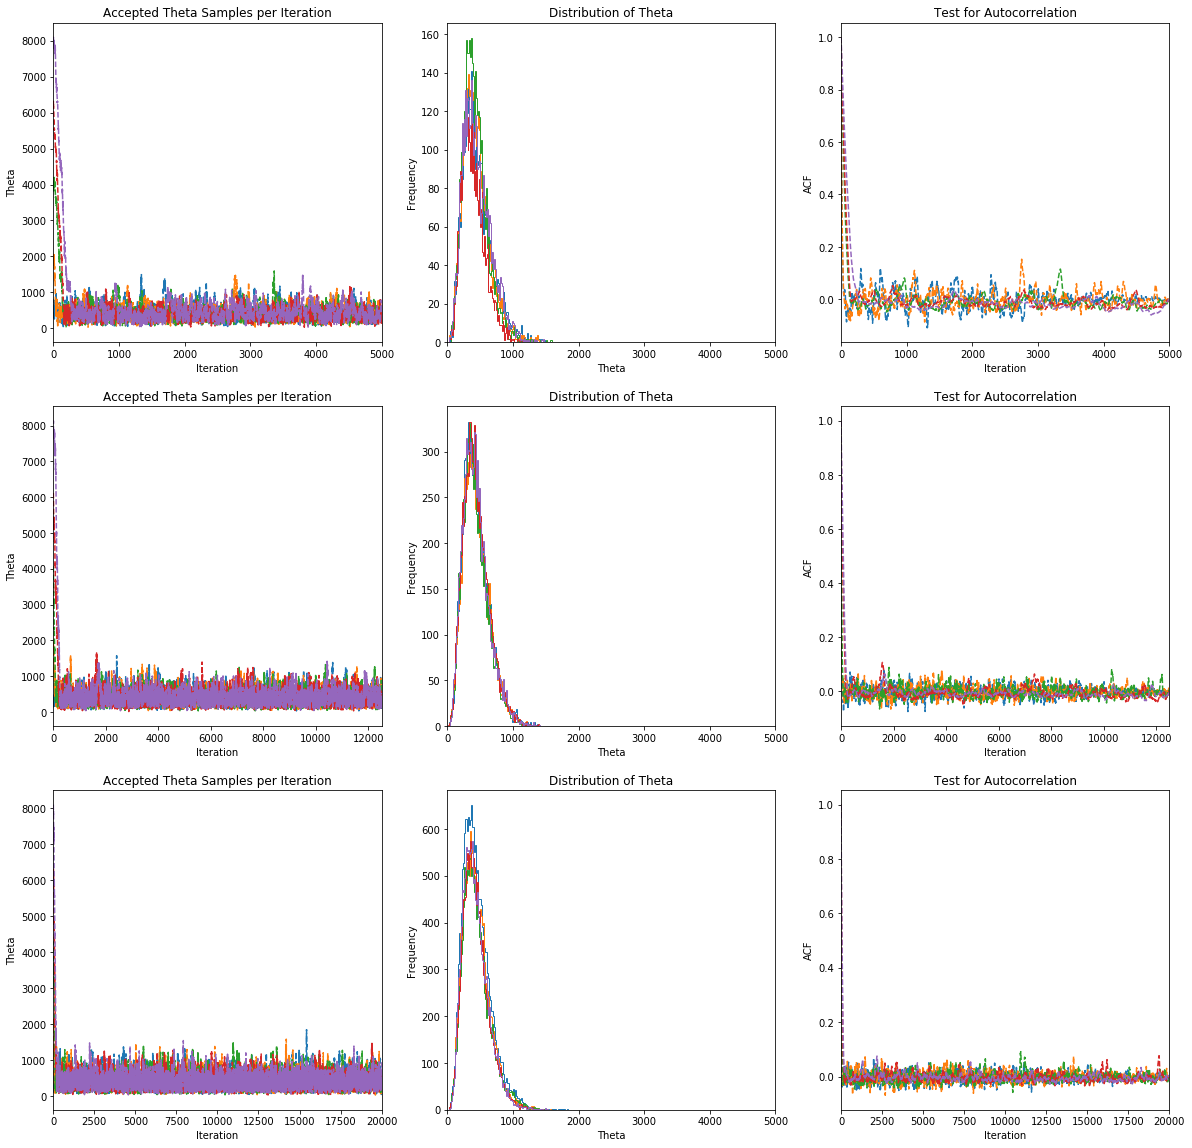

In [26]:
from scipy.stats import gamma, norm, lognorm, weibull_min

niters = np.linspace(5e3,2e4,3)
cnt = 1

fig = plt.figure(figsize=(20,20))

for i in range(len(niters)):
    print("iter: %s" %niters[i])
    
    # select a sigma for the algo, 
    # a range too wide gives you lower chances of accepting samples but allows more room for the candidate data to roam
    # a range too narrow gives you higher chance of accepting samples but samples may not converge
    sigma = 100

    # select different starting points for mu based on its range
    sampless = [mh(niters[i], mu_, sigma, gamma, 4.3, 100).run() for mu_ in np.arange(100, 10000, 2000)]
    
    # Samples plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:    
        ax.plot(samples, '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('Theta')
    ax.set_xlabel('Iteration')
    ax.set_title('Accepted Theta Samples per Iteration')
    cnt += 1
    
    # Distribution plot
    ax = fig.add_subplot(3,3,i+cnt)
    last_n_samples = int(niters[i] * 0.8)
    for samples in sampless:
        ax.hist(samples[-last_n_samples:], bins=100, histtype='step', label=f'{niters[i]}')
    ax.set_xlim([0, 5000])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Theta')
    ax.set_title('Distribution of Theta')
    cnt += 1
    
    # Auto-correlation plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:
        ax.plot(mc.autocorr.function_1d(samples), '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('ACF')
    ax.set_xlabel('Iteration')
    ax.set_title('Test for Autocorrelation')

plt.show()

### Significance test for autocorrelation

In [ ]:
import statsmodels as sm

# Dublin-Watson test for autocorrelation
sm.stats.stattools.durbin_watson

## Case 4: Simulate ex-China infection numbers
#### Data source: CoronaTracker.com
- switching to this data source because the previous data source for overseas numbers is not reliable

In [27]:
# import MySQLdb

# myDB = MySQLdb.connect(host="coronatracker.coehycitad7u.ap-southeast-1.rds.amazonaws.com",\
#                        port=3306,passwd="corona0106",db="coronatracker")
# cHandler = myDB.cursor()

In [28]:
# connection_string = (
#     'DRIVER=MySQL ODBC 8.0 ANSI Driver;'
#     'SERVER="coronatracker.coehycitad7u.ap-southeast-1.rds.amazonaws.com";'
#     'DATABASE=coronatracker;'
#     'UID=root;'
#     'PWD=corona0106;'
#     'charset=utf8mb4;'
# )

In [29]:
# import pyodbc
# con = pyodbc.connect(connection_string)

In [31]:
case_exChina = df[(df['countryCode']!='CN') & (df['province'].isnull()) \
                 & (df['city'].isnull())].groupby('date').agg({'confirmed':'sum'}).reset_index()

In [32]:
case_exChina['new infected'] = case_exChina['confirmed'].diff().fillna(1)

In [33]:
df[(df['countryCode']!='CN') & (df['province'].isnull()) \
                 & (df['city'].isnull())]

,date,country,countryCode,province,city,confirmed,suspected,cured,dead,Days,net_confirmed
141,2020-01-16,日本,JP,NaN,NaN,1,0,0,0,39,1
142,2020-01-16,泰国,TH,NaN,NaN,1,0,0,0,39,1
170,2020-01-20,日本,JP,NaN,NaN,1,0,0,0,43,1
171,2020-01-20,韩国,KR,NaN,NaN,1,0,0,0,43,1
172,2020-01-20,泰国,TH,NaN,NaN,2,0,0,0,43,2
...,...,...,...,...,...,...,...,...,...,...,...
7363,2020-02-20,瑞典,SE,NaN,NaN,1,0,0,0,74,1
7364,2020-02-20,新加坡,SG,NaN,NaN,85,0,37,0,74,48
7365,2020-02-20,泰国,TH,NaN,NaN,35,0,17,0,74,18
7366,2020-02-20,美国,US,NaN,NaN,15,0,3,0,74,12


In [34]:
case_exChina

,date,confirmed,new infected
0,2020-01-16,2,1.0
1,2020-01-20,4,2.0
2,2020-01-21,5,1.0
3,2020-01-22,6,1.0
4,2020-01-23,9,3.0
5,2020-01-24,18,9.0
6,2020-01-25,23,5.0
7,2020-01-26,33,10.0
8,2020-01-27,41,8.0
9,2020-01-28,56,15.0


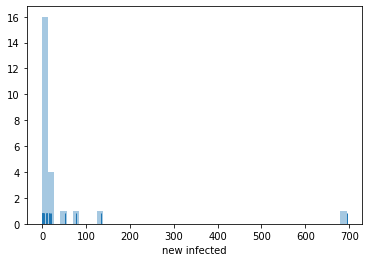

In [35]:
sb.distplot(case_exChina['new infected'], bins=50, kde=False, rug=True)

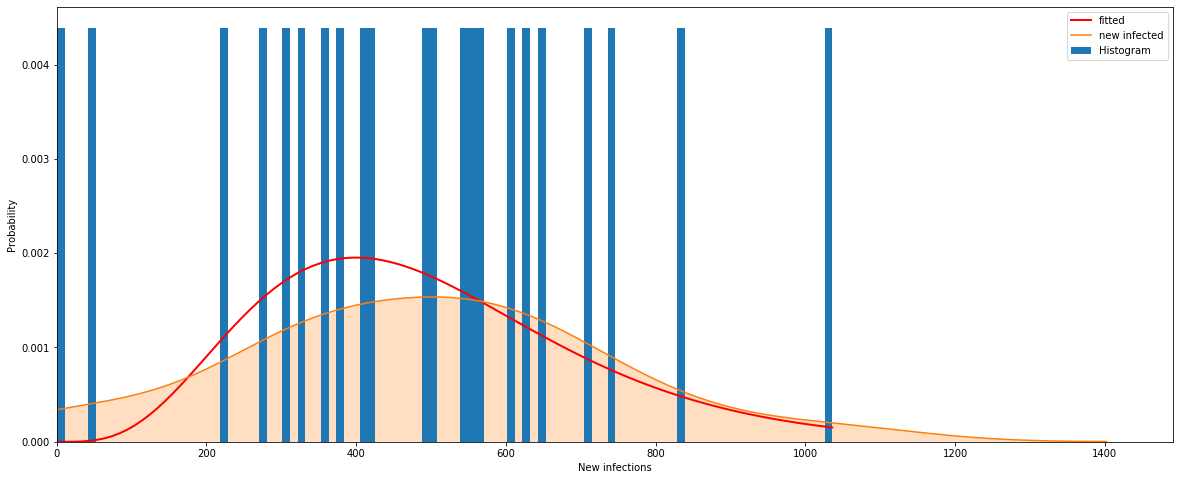

In [36]:
shape, scale = 5, 100 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_exHubei['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_exHubei['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [37]:
mu = case_exHubei['new infected'].mean()
sigma = case_exHubei['new infected'].std()
mu, sigma

(482.8636363636364, 244.26864513414526)

iter: 5000.0
Theta: 100
Mean of samples: 500.73881487634907, Stddev of samples: 240.8119424646043
Theta: 2100
Mean of samples: 517.0826002259726, Stddev of samples: 215.34957145004591
Theta: 4100
Mean of samples: 537.4422354489501, Stddev of samples: 331.1992412155002
Theta: 6100
Mean of samples: 595.462884606341, Stddev of samples: 601.7706392678255
Theta: 8100
Mean of samples: 680.7980477459245, Stddev of samples: 898.9538404263928
iter: 12500.0
Theta: 100
Mean of samples: 502.86836093536766, Stddev of samples: 209.6612208903272
Theta: 2100
Mean of samples: 500.78672186958147, Stddev of samples: 212.58806945540158
Theta: 4100
Mean of samples: 520.5089978972325, Stddev of samples: 290.01268266577745
Theta: 6100
Mean of samples: 549.6152907512836, Stddev of samples: 488.66924982690733
Theta: 8100
Mean of samples: 536.6832930883556, Stddev of samples: 484.89606330412295
iter: 20000.0
Theta: 100
Mean of samples: 508.4467950370816, Stddev of samples: 221.62674274002904
Theta: 2100
Mean of

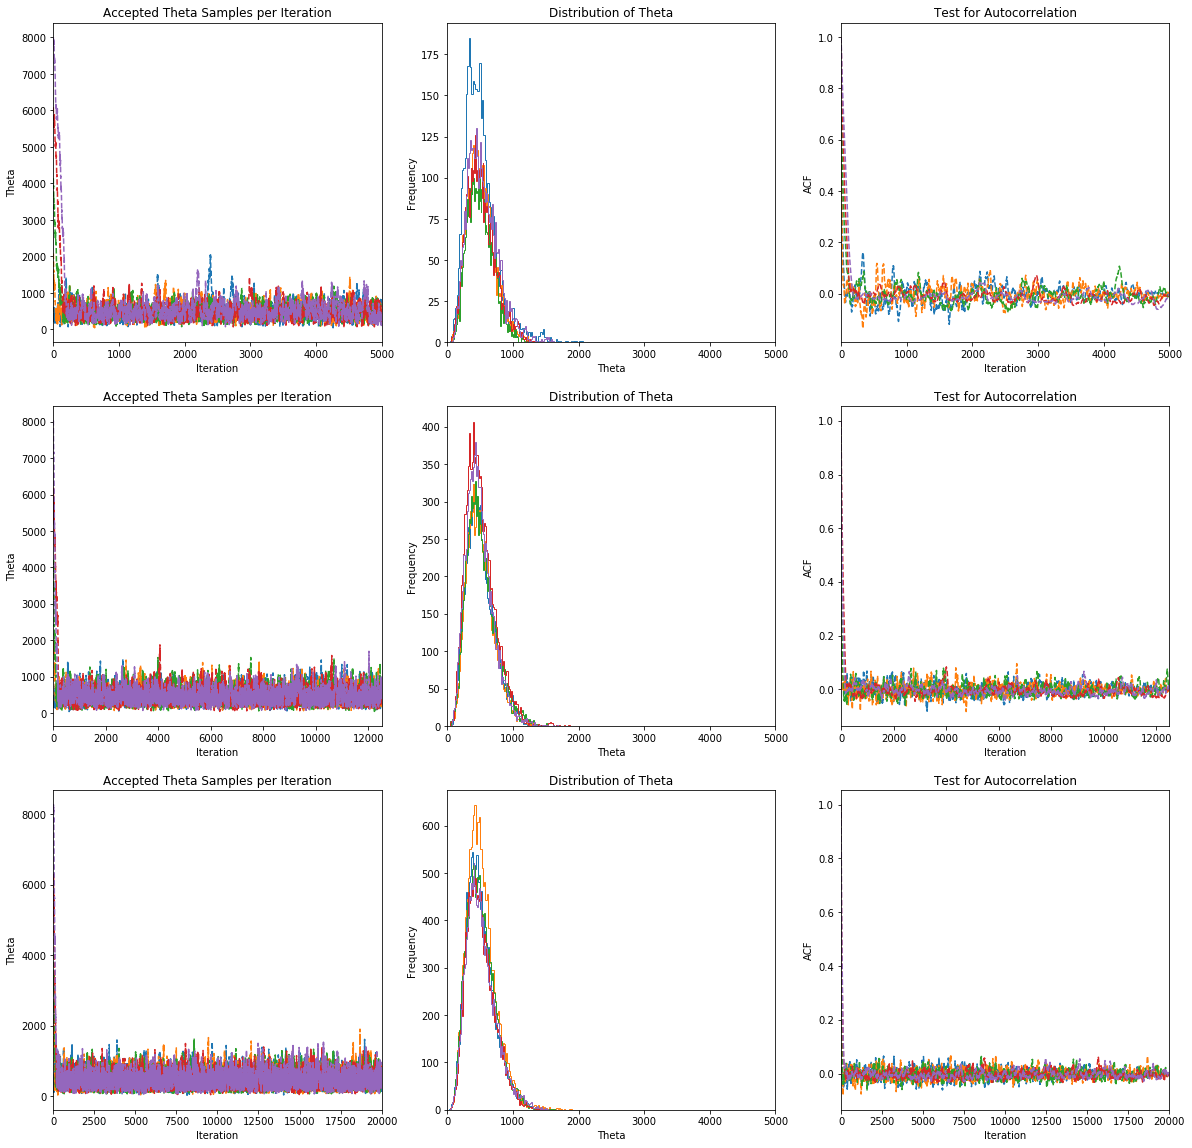

In [38]:
from scipy.stats import gamma, norm, lognorm, weibull_min

niters = np.linspace(5e3,2e4,3)
cnt = 1

fig = plt.figure(figsize=(20,20))

for i in range(len(niters)):
    print("iter: %s" %niters[i])
    
    # select a sigma for the algo, 
    # a range too wide gives you lower chances of accepting samples but allows more room for the candidate data to roam
    # a range too narrow gives you higher chance of accepting samples but samples may not converge
    sigma = 100

    # select different starting points for mu based on its range
    sampless = [mh(niters[i], mu_, sigma, gamma, 5, 100).run() for mu_ in np.arange(100, 10000, 2000)]
    
    # Samples plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:    
        ax.plot(samples, '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('Theta')
    ax.set_xlabel('Iteration')
    ax.set_title('Accepted Theta Samples per Iteration')
    cnt += 1
    
    # Distribution plot
    ax = fig.add_subplot(3,3,i+cnt)
    last_n_samples = int(niters[i] * 0.8)
    for samples in sampless:
        ax.hist(samples[-last_n_samples:], bins=100, histtype='step', label=f'{niters[i]}')
    ax.set_xlim([0, 5000])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Theta')
    ax.set_title('Distribution of Theta')
    cnt += 1
    
    # Auto-correlation plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:
        ax.plot(mc.autocorr.function_1d(samples), '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('ACF')
    ax.set_xlabel('Iteration')
    ax.set_title('Test for Autocorrelation')

plt.show()

## References

In [ ]:
import copy

prev_draw = np.random.normal(mu,sigma) #Initialize x(0) ∼ q(x)
sample = []
steps = 1000

for i in range(1, steps):
    if i == 0:
        prev_draw = copy.copy(mu)
    else:
        current = np.random.normal(mu,sigma)
        candidate = transition_model(current, prev_draw) #Propose: x_cand ∼ q(x(i)|x(i−1))
        print("%s, current: %s candidate: %s" %(i,current,candidate))
        T_next = target_model(candidate) # π(x_cand)q(x(i−1)|x_cand)
        T_prev = target_model(current) #   π(x(i−1))q(x_cand|x(i−1))
        a = min(1, max(T_next / T_prev,0)) # Acceptance Probability

        if a > np.random.uniform(0, 1): # u ∼ Uniform (u; 0, 1)
            # Update state
            print("accepted, current: %s candidate: %s" %(current,candidate))
            current = copy.copy(candidate) # Accept the proposal: x(i) ← x_cand
            sample.append(current)
print('Accept ratio:', float(len(sample)) / steps)

In [ ]:
# P(x) : Target distribution
def P(x1, x2, b):
    return np.exp(-0.5 * (x1**2 - 2*b*x1*x2 + x2**2))


# Q(x) : Proposal distribution
def Q(c, mu1, mu2, sigma):
    return (c[0] * np.random.normal(mu1, sigma), c[1] * np.random.normal(mu2, sigma))

def metropolisHastings(mu, sigma):
    current = (10, 10)
    sample = []
    sample.append(current)
    accept_ratio = []

    for i in range(N):
        candidate = Q(current, mu1, mu2, sigma)

        T_prev = P(current[0], current[1], b)
        T_next = P(candidate[0], candidate[1], b)
        a = T_next / T_prev

        if a > 1 or a > np.random.uniform(0, 1):
            # Update state
            current = copy.copy(candidate)
            sample.append(current)
            accept_ratio.append(i)

    print('Accept ratio:', float(len(accept_ratio)) / N)
    return np.array(sample)

Text(0, 0.5, 'Frequency')

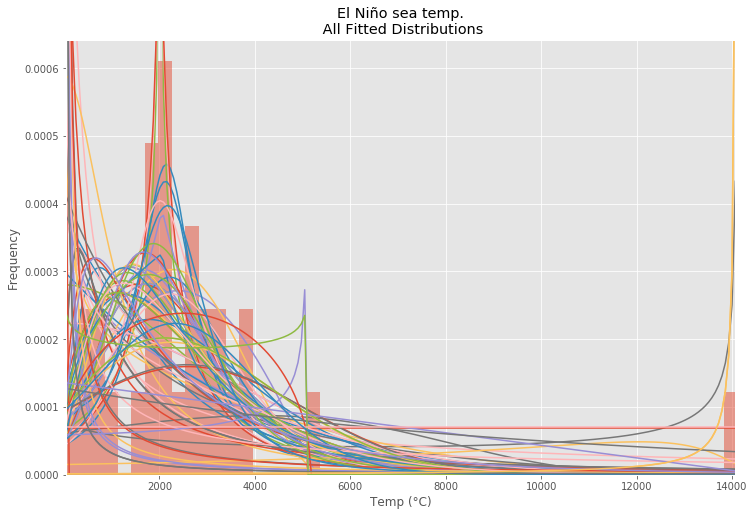

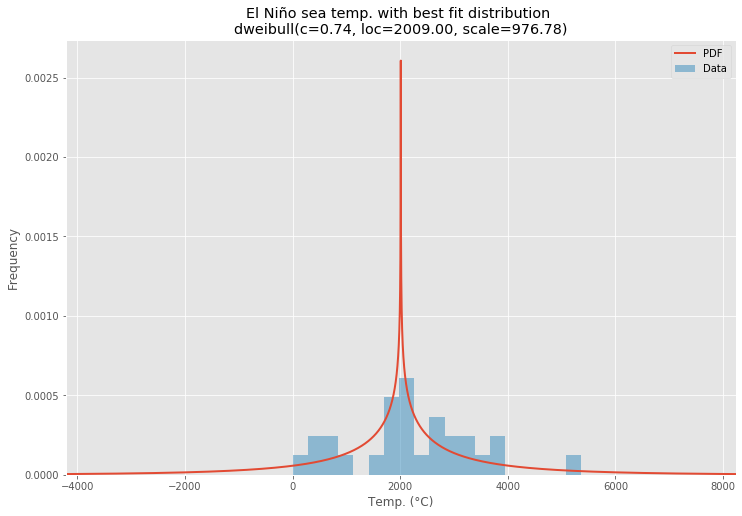

In [30]:
import scipy.stats as st


import matplotlib
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = case['new infected']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [3]:
df_blanker = pd.read_csv('./csv/DXYArea.csv')
print(df_blanker.shape)
# df_blanker = df_blanker[df_blanker['provinceEnglishName']=='Hubei']
df_blanker['date'] = df_blanker['updateTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())
df_daily_max_datetime = df_blanker.groupby(['date','cityName']).agg({'updateTime':'max'}).reset_index()
df_daily_max = pd.merge(df_daily_max_datetime, df_blanker, on=['updateTime','date','cityName'], how='inner')
covid_cn = df_daily_max.groupby('date').agg({'city_confirmedCount':'sum'}).reset_index()
covid_cn = covid_cn.iloc[:-1 ,:] ## remove today's data as it will not be complete
covid_cn.columns = ['date','infected']
print(covid_cn.shape)
covid_cn['new infected'] = covid_cn['infected'].diff().fillna(1)

(44066, 15)
(25, 2)
